In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display


# 狗狼狐狸傻傻分不清楚

![Alt text](../images/animals.png)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.3.2
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.3.1.


In [3]:
#調用預訓練模型
#調用的模型會放置在 ~\.trident\models
resnet50=ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=1000,)

archive file is already existing, donnot need download again.


<p>傳回的ResNet50的型別是名為<em>ImageClassificationModel</em>的Model子類，ImageClassificationModel需要滿足<em>class_names(標籤清單)不為空</em>以及<em>preprocess_flow的清單內放置推論前需要的圖像處理函數</em>，這樣就可以直接調用infer_single_image(img,topk=1)來進行推論，當然，這邊的預訓練模型都已經幫大家設定好了，大家不需要做任何處理，但還是讓大家瞭解一下內部到底做了些甚麼，以ResNet50為例，他的preprocess_flow設定如下：</p>

<pre><code>
preprocess_flow=[resize((224,224),keep_aspect=True),#不扭曲比例縮放至224,224
    normalize(0,255), #像素除以255
    normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),#透過imagenet像素均值標準差再做一次正規化
    ]
</code></pre>

<p>至於infer_single_image(img,topk=1)這個函數中，img可以傳入的是一個<em>圖檔路徑</em>，或者是<em>PIL讀取的圖檔</em>，也可以是一個<em>圖檔向量(通道在後，RGB)</em></p>

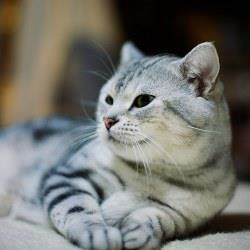

In [4]:
im=read_image('../images/cat.jpg')
im

In [5]:
print(resnet50.infer_single_image(read_image('../images/cat.jpg'),5))

OrderedDict([(' n02124075\t埃及猫', (285, 0.0024988495)), (' n02123045\t虎斑猫', (281, 0.0010442982)), (' n02123159\t山猫', (282, 0.001030529)), (' n02128757\t雪豹', (289, 0.0010019365)), (' n02129604\t老虎', (292, 0.0009988637))])


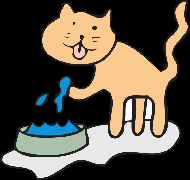

In [6]:
im=read_image('../images/manka.png')
im

In [7]:
print(resnet50.infer_single_image(read_image('../images/manka.png'),5))

OrderedDict([(' n03666591\t點火器', (626, 0.0011028178)), (' n06359193\t網站', (916, 0.0010799888)), (' n06596364\t漫畫', (917, 0.0010707519)), (' n03595614\t運動衫', (610, 0.00106817)), (' n03063599\t咖啡杯', (504, 0.0010576944))])


In [8]:
dataset=T.load_examples_data('animals')
dataset.image_transform_funcs=[
                     random_center_crop(224,224,scale=(0.8,1.4)),
                     #原比例隨機縮放(正確縮放比例再乘上0.8~1.2之間隨機數)中央裁切至224,224
                     random_adjust_gamma(gamma=(0.8,1.2)),
                     #隨機調整圖片明暗gamma 0.6~1.4之間
                     random_contast(scale=(0.8, 1.2)),
                     #隨機調整圖片對比度
                     normalize(0,255),#除以255
                     normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])] #透過imagenet像素均值標準差再做一次正規化
dataset.minibatch_size=16

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
Mapping data  in train scenario  success, total 35414 record addeds.
Mapping label  in train scenario  success, total 35414 records added.
Mapping class_names  in en-us   success, total 12 class names added.


In [9]:
finetune_resnet50=ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=12)


archive file is already existing, donnot need download again.


In [10]:
finetune_resnet50.summary()

--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                             first_block             [-1, 64, 112, 112]                                                                0              0.0
                            batch_norm_1             [-1, 64, 112, 112]                            [64]            [64]              128      2,395,904.0
                            max_pool2d_1               [-1, 64, 56, 56]                                                                0              0.0
                         layer1.0_0_conv               [-1, 64, 56, 56]                                                                0              0.0
                            batch_norm_3               [-1, 64, 56, 56]                            [6

In [11]:
finetune_resnet50.model.trainable=False
finetune_resnet50.summary()

23532620 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                             first_block             [-1, 64, 112, 112]                                                                0              0.0
                            batch_norm_1             [-1, 64, 112, 112]                            [64]            [64]              128      2,395,904.0
                            max_pool2d_1               [-1, 64, 56, 56]                                                                0              0.0
                         layer1.0_0_conv               [-1, 64, 56, 56]                                                                0              0.0
                            batch_norm_3               [-1, 

In [12]:
finetune_resnet50.model.fc.trainable=True

finetune_resnet50.summary()

24588 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                             first_block             [-1, 64, 112, 112]                                                                0              0.0
                            batch_norm_1             [-1, 64, 112, 112]                            [64]            [64]              128      2,395,904.0
                            max_pool2d_1               [-1, 64, 56, 56]                                                                0              0.0
                         layer1.0_0_conv               [-1, 64, 56, 56]                                                                0              0.0
                            batch_norm_3               [-1, 64, 5

In [13]:
#自訂callbacks
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_batch_end(self, training_context):
        if training_context['current_batch']==0:
            print(training_context['losses'])   #列印各個loss值
        if training_context['current_batch']==200:
            training_context['current_model'].layer4.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_batch']>0 and training_context['current_batch']%1000==0:
            training_context['optimizer'].lr=training_context['optimizer'].lr*0.5
            #每訓練1000批次，學習速率降一半
    

In [14]:
finetune_resnet50=finetune_resnet50\
    .with_optimizer(optimizer='Ranger',lr=1e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/finetune_resnet50.pth')

![Alt text](../images/animals_overview.jpg)

![Alt text](../images/cutmix.png)

In [15]:
finetune_resnet50=finetune_resnet50\
    .with_callbacks(CutMixCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.5))\
    .with_callbacks(MixupCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(CustomCallback())

plan=TrainingPlan()\
    .add_training_item(finetune_resnet50)\
    .with_data_loader(dataset)\
    .repeat_epochs(20)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .save_model_scheduling(200,unit='batch')

In [26]:
plan.start_now()


<bound method TrainingPlan.__repr__ of TrainingPlan(
  (training_items): ImageClassificationModel(
    (inputs): Input()
    (model): Sequential(
      (first_block): Conv2d_Block(
        kernel_size=(7, 7), 64, strides=2, activation=relu
        (norm): BatchNorm(64, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
        (conv): Conv2d(kernel_size=(7, 7), 64,strides=(2, 2),auto_pad=True,use_bias=False ,dilation=(1, 1), input_shape=[3, 224, 224], input_filter=3, output_shape=[64, 112, 112])
      )
      (maxpool): MaxPool2d(kernel_size=(3, 3), strides=(2, 2), padding=(0, 0), dilation=1)
      (layer1): Sequential(
        (0): ShortCut2d(
          (branch1): Sequential(
            (0): Conv2d_Block(
              kernel_size=(1, 1), 64, strides=1, activation=relu
              (norm): BatchNorm(64, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
              (conv): Conv2d(kernel_size=(1, 1), 64,strides=(1, 1),auto_pad=True,use_bias=False ,dilation

In [17]:
#finetune_resnet50.class_names=dataset.class_names['en-us']
finetune_resnet50.class_names=['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']
print(finetune_resnet50.class_names)

['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']


In [18]:
print(finetune_resnet50.infer_single_image(read_image('../images/captaincat.jpg'),5))

OrderedDict([('貓 cat', (0, 0.12705576)), ('狗 dog', (2, 0.1207035)), ('馴鹿 reindeer', (7, 0.07535429)), ('天竺鼠 guinea pig', (5, 0.07521477)), ('狐狸 fox', (3, 0.0752139))])


OrderedDict([('長頸鹿 giraffe', (4, 0.19362886)), ('狼 wolf', (11, 0.07477373)), ('梅花鹿 sikadeer', (8, 0.0733781))])


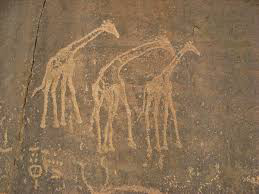

In [19]:
im=read_image('../images/africa.jpg')
print(finetune_resnet50.infer_single_image(read_image('../images/africa.jpg'),3))
im

OrderedDict([('天竺鼠 guinea pig', (5, 0.12503849)), ('貓 cat', (0, 0.11913108)), ('狼 wolf', (11, 0.07771487))])


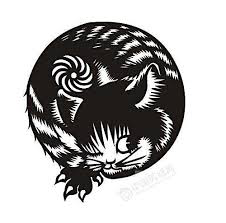

In [20]:
im=read_image('../images/paper.jpg')
print(finetune_resnet50.infer_single_image(read_image('../images/paper.jpg'),3))
im

OrderedDict([('貓 cat', (0, 0.19715363)), ('狐狸 fox', (3, 0.07335551)), ('狗 dog', (2, 0.07295744))])


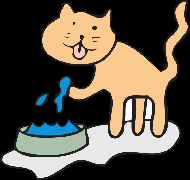

In [21]:
im=read_image('../images/manka.png')
print(finetune_resnet50.infer_single_image(read_image('../images/manka.png'),3))
im

OrderedDict([('狼 wolf', (11, 0.19810656)), ('馴鹿 reindeer', (7, 0.07291422)), ('狐狸 fox', (3, 0.07289829))])


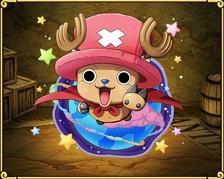

In [22]:
im=read_image('../images/joba.jpg')
print(finetune_resnet50.infer_single_image(read_image('../images/joba.jpg'),3))
im

OrderedDict([('狗 dog', (2, 0.17452091)), ('鬣狗 hyena', (6, 0.082941286)), ('長頸鹿 giraffe', (4, 0.07591579))])


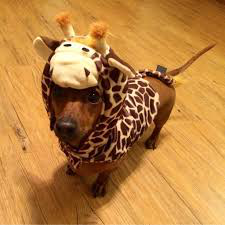

In [23]:
im=read_image('../images/fakegiraffe.jpg')
print(finetune_resnet50.infer_single_image(read_image('../images/fakegiraffe.jpg'),3))
im

OrderedDict([('天竺鼠 guinea pig', (5, 0.19583045)), ('貓 cat', (0, 0.07383481)), ('狼 wolf', (11, 0.073156))])


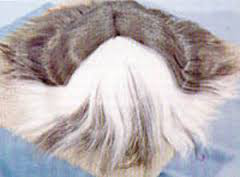

In [24]:
im=read_image('../images/longhair.jpg')#這是稀有品種長毛天竺鼠
print(finetune_resnet50.infer_single_image(read_image('../images/longhair.jpg'),3))
im